## Self-adapting differential evolutionary algorithm (SaDE)

In [ ]:
import math
from statistics import median, stdev
from random import uniform, choice, randint, gauss
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
class Individual:
    '''This is the class for single individual'''
    
    def __init__(self, x_min, x_max, dim):
        self.__pos = np.array([x_min + random.random()*(x_max - x_min) for i in range(dim)])
        self.__mutation = np.array([0.0 for i in range(dim)])  # The individual after mutation
        self.__crossover = np.array([0.0 for i in range(dim)])  # The individual after crossover
        self.__fitnessValue = fit_fun(self.__pos)  # The fitness value for this individual

    def set_pos(self, i, value):
        self.__pos[i] = value

    def get_pos(self):
        return self.__pos

    def set_mutation(self, i, value):
        self.__mutation[i] = value

    def get_mutation(self):
        return self.__mutation

    def set_crossover(self, i, value):
        self.__crossover[i] = value

    def get_crossover(self):
        return self.__crossover

    def set_fitness_value(self, value):
        self.__fitnessValue = value

    def get_fitness_value(self):
        return self.__fitnessValue


The best combination (position):[-8.055023474133653, 9.664590032556724]
The best result:-19.208502567886754


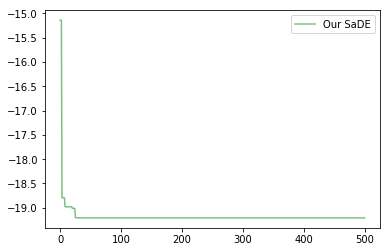

In [34]:
class SaDE:

    def __init__(self):
        self.pop = [] #population's positions        
        self.m_nmdf = 0.00 #diversity variable
        self.diversity = []
        self.fbest_list = []
        self.ns1 = 0
        self.ns2 = 0
        self.nf1 = 0
        self.nf2 = 0
        
        self.fitness_val_list = []  # This list is to include the best fitness score in every single iter                                                
        
    def updateDiversity(self):
        diversity = 0
        aux_1 = 0
        aux2 = 0
        a = 0
        b = 0
        d = 0
        
       
        for a in range(0, len(self.pop)):
            b = a+1
            for i in range(b, len(self.pop)):
                aux_1 = 0
    
                ind_a = self.pop[a]
                ind_b = self.pop[b]
    
                for d in range(0, len(self.pop[0])):
                    aux_1 = aux_1 + (pow(ind_a[d] - ind_b[d], 2).real)
                aux_1 = (math.sqrt(aux_1).real)
                aux_1 = (aux_1 / len(self.pop[0]))
    
                if b == i or aux_2 > aux_1:
                    aux_2 = aux_1
            diversity = (diversity) + (math.log((1.0) + aux_2).real)
            
        if self.m_nmdf < diversity:
            self.m_nmdf = diversity

        return (diversity/self.m_nmdf).real

    #fitness_function
    def fitness(self, X):
    
        # Use holden table function
        return -np.abs(np.sin(X[0]) * np.cos(X[1]) * np.exp(np.abs(1 - np.sqrt(X[0] ** 2 + X[1] ** 2) / np.pi)))
   
    def generatePopulation(self, pop_size, dim, bounds):      
        for ind in range(pop_size):
            lp = []
            for d in range(dim):
                lp.append(uniform(bounds[d][0],bounds[d][1]))
            self.pop.append(lp)

    def evaluatePopulation(self):
        fpop = []
        for ind in self.pop:
            fpop.append(self.fitness(ind)) 
        return fpop 

    def getBestSolution(self, maximize, fpop):
        fbest = fpop[0]
        best = [values for values in self.pop[0]]
        for ind in range(1,len(self.pop)):
            if maximize == True:
                if fpop[ind] >= fbest:
                    fbest = float(fpop[ind])
                    best = [values for values in self.pop[ind]]
            else:     
                if fpop[ind] <= fbest:
                    fbest = float(fpop[ind])
                    best = [values for values in self.pop[ind]]

        return fbest,best

    def rand_1_bin(self, ind, dim, wf, cr):
        p1 = ind
        while(p1 == ind):
            p1 = choice(self.pop)
        p2 = ind
        while(p2 == ind or p2 == p1):
            p2 = choice(self.pop)
        p3 = ind
        while(p3 == ind or p3 == p1 or p3 == p2):
            p3 = choice(self.pop)
        
        cutpoint = randint(0, dim-1)
        candidateSol = []

        for i in range(dim):
            if(i == cutpoint or uniform(0,1) < cr):
                candidateSol.append(p3[i]+wf*(p1[i]-p2[i])) # -> rand(p3) , vetor diferença (wf*(p1[i]-p2[i]))i
            else:
                candidateSol.append(ind[i])

        return candidateSol
    
    def currentToBest_2_bin(self, ind, best, dim, wf, cr):
        p1 = ind
        while(p1 == ind):
            p1 = choice(self.pop)
        p2 = ind
        while(p2 == ind or p2 == p1):
            p2 = choice(self.pop)

        cutpoint = randint(0, dim-1)
        candidateSol = []
    
        for i in range(dim):
            if(i == cutpoint or uniform(0,1) < cr):
                candidateSol.append(ind[i]+wf*(best[i]-ind[i])+wf*(p1[i]-p2[i])) # -> rand(p3) , vetor diferença (wf*(p1[i]-p2[i]))
            else:
                candidateSol.append(ind[i])
        
        return candidateSol

    def boundsRes(self, ind, bounds):
        for d in range(len(ind)):
            if ind[d] < bounds[d][0]:
                ind[d] = bounds[d][0] 
            if ind[d] > bounds[d][1]:
                ind[d] = bounds[d][1] 

    def diferentialEvolution(self, pop_size, dim, bounds, max_iterations, runs, maximize=True, p1=0.5, p2=0.5, learningPeriod=50, crPeriod=5, crmUpdatePeriod=25):
        #generete execution identifier
        
        avr_fbest_r = []
        avr_diversity_r = []
        fbest_r = []
        best_r = []
        elapTime_r = []
        
        #runs
        for r in range(runs):
            
            #start the algorithm
            best = [] #global best positions
            fbest = 0.00
                    
            #global best fitness
            if maximize == True:
                fbest = 0.00
            else:
                fbest = math.inf

            #initial_generations
            self.generatePopulation(pop_size, dim, bounds)
            fpop = self.evaluatePopulation()

            fbest,best = self.getBestSolution(maximize, fpop)
            
            #evolution_step
            # generates crossover rate values
            crm = 0.5
            crossover_rate = [gauss(crm, 0.1) for i in range(pop_size)]
            cr_list = []
            for iteration in range(max_iterations):
                avrFit = 0.00
                # #update_solutions
                strategy = 0
                for ind in range(0,len(self.pop)):
                    # generate weight factor values
                    weight_factor = gauss(0.5, 0.3)
                    if uniform(0,1) < p1:
                        candSol = self.rand_1_bin(self.pop[ind], dim, weight_factor, crossover_rate[ind])
                        strategy = 1
                    else:
                        candSol = self.currentToBest_2_bin(self.pop[ind], best, dim, weight_factor, crossover_rate[ind])
                        strategy = 2
                    
                    self.boundsRes(candSol, bounds)
                    fcandSol = self.fitness(candSol)

                    if maximize == False:
                        if fcandSol <= fpop[ind]:
                            self.pop[ind] = candSol
                            fpop[ind] = fcandSol
                            cr_list.append(crossover_rate[ind])
                            if strategy == 1:
                                self.ns1+=1
                            elif strategy == 2:
                                self.ns2+=1
                        else:
                            if strategy == 1:
                                self.nf1+=1
                            elif strategy == 2:
                                self.nf2+=1
                    else:
                        if fcandSol >= fpop[ind]:
                            self.pop[ind] = candSol
                            fpop[ind] = fcandSol
                            cr_list.append(crossover_rate[ind])
                            if strategy == 1:
                                self.ns1+=1
                            elif strategy == 2:
                                self.ns2+=1
                        else:
                            if strategy == 1:
                                self.nf1+=1
                            elif strategy == 2:
                                self.nf2+=1
                    
                    avrFit += fpop[ind]
                fbest,best = self.getBestSolution(maximize, fpop)
                self.fitness_val_list.append(fbest)
                    
                avrFit = avrFit/pop_size
                self.diversity.append(self.updateDiversity())

                fbest,best = self.getBestSolution(maximize, fpop)
                
                self.fbest_list.append(fbest)
                
                if iteration%crPeriod == 0 and iteration!=0:
                    crossover_rate = [gauss(crm, 0.1) for i in range(pop_size)]
                    if iteration%crmUpdatePeriod == 0:
                        crm = sum(cr_list)/len(cr_list)
                        cr_list = []

                if iteration%learningPeriod == 0 and iteration!=0: 
                    p1 = (self.ns1*(self.ns2+self.nf2))/(self.ns2*(self.ns1+self.nf1)+self.ns1*(self.ns2+self.nf2))
                    p2 = 1-p1
                    self.nf2 = 0
                    self.ns1 = 0
                    self.ns2 = 0
                    self.nf1 = 0

            
            fbest_r.append(fbest)
            best_r.append(best)
            
            avr_fbest_r.append(self.fbest_list)
            avr_diversity_r.append(self.diversity)
        
        fbestAux = [sum(x)/len(x) for x in zip(*avr_fbest_r)]
        diversityAux = [sum(x)/len(x) for x in zip(*avr_diversity_r)]
        
        return self.fitness_val_list, best_r
        
max_iterations = 500 
pop_size = 6
dim = 2
runs = 1
bounds = ((-10,10), (-10,10), (-10,10), (-10,10))
p = SaDE()

fit_var_list2, best_pos2= p.diferentialEvolution(pop_size, dim, bounds, max_iterations, runs, maximize=False)

print("The best combination (position):" + str(best_pos2[-1]))
print("The best result:" + str(fit_var_list2[-1]))

plt.plot(np.linspace(0, max_iterations, max_iterations), fit_var_list2, c="G", alpha=0.5, label="Our SaDE")

plt.legend()
plt.show()